In [1395]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import seaborn as sns
import statsmodels.api as sm
import random
from sklearn.feature_selection import SequentialFeatureSelector #Para stepwise
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV, Ridge #Para Ridge
from sklearn.linear_model import LassoCV,Lasso

plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')
random.seed(123)

## Extracción de datos

In [1396]:
songs_df = pd.read_csv('songs.csv')

songs_df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


## Separar las variables Categóricas y Numéricas

### Extracción de variables numéricas

In [1397]:
numerical_cols = [cname for cname in songs_df.columns if songs_df[cname].dtype in ['int64', 'float64']]
numerical_cols.remove('mode')
print("Variables numericas: ",numerical_cols)
print("Cantidad: ", len(numerical_cols))

Variables numericas:  ['duration_ms', 'year', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Cantidad:  13


### Extracción de variables categóricas

In [1398]:
categorical_cols = [cname for cname in songs_df.columns if songs_df[cname].dtype in ["object", "bool"]]
categorical_cols.append('mode')
print("Variables categoricas: ",categorical_cols)
print("Cantidad: ", len(categorical_cols))

Variables categoricas:  ['artist', 'song', 'explicit', 'genre', 'mode']
Cantidad:  5


### Mapa de correlación de las variables

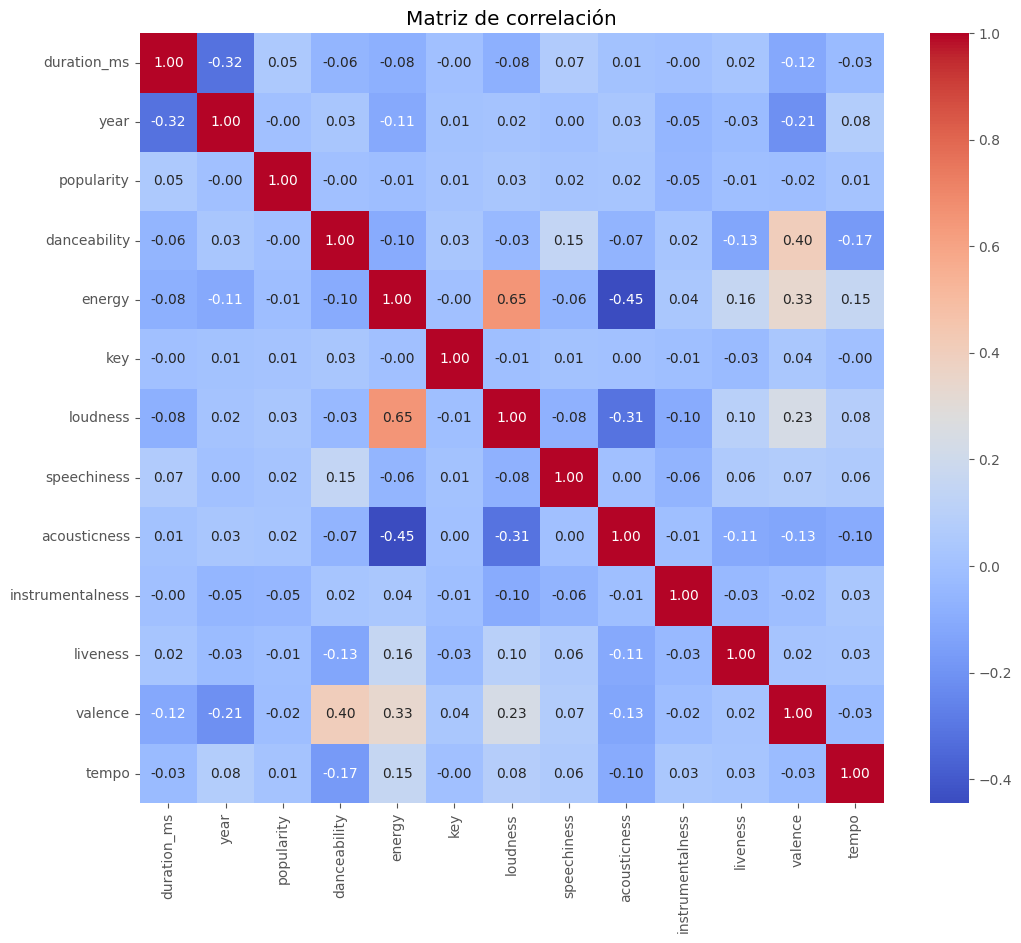

In [1399]:
correlation_matrix = songs_df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.title("Matriz de correlación")
plt.show()

En el mapa podemos observar como es no existe correlación en casi todas las variables, exceptuando en entre las variables de 'danceability' y 'loudness', estás presentan una leve correlación entre ellas.

## Análisis de variables numéricas

### Análisis de valores atípicos

<Axes: >

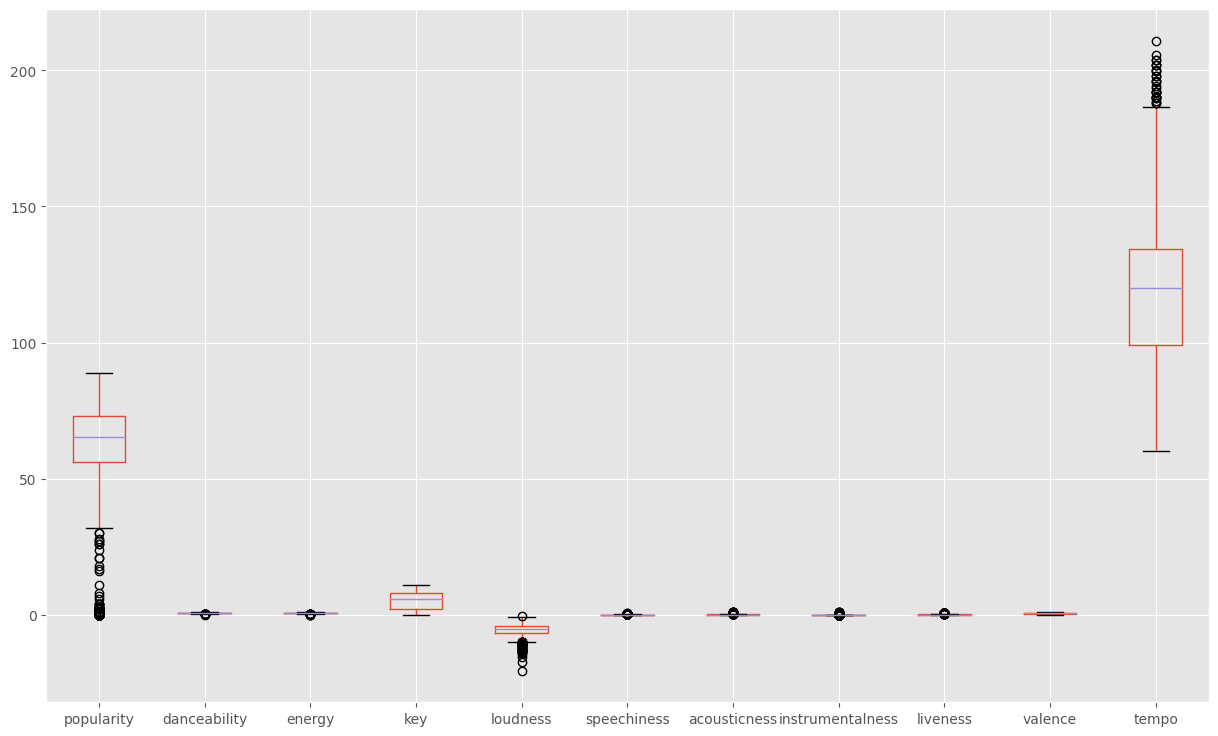

In [1400]:
songs_df[['popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].boxplot()

Podemos notar que en lo general no existen valores atípicos en las variables de nuestro set de datos

<Axes: >

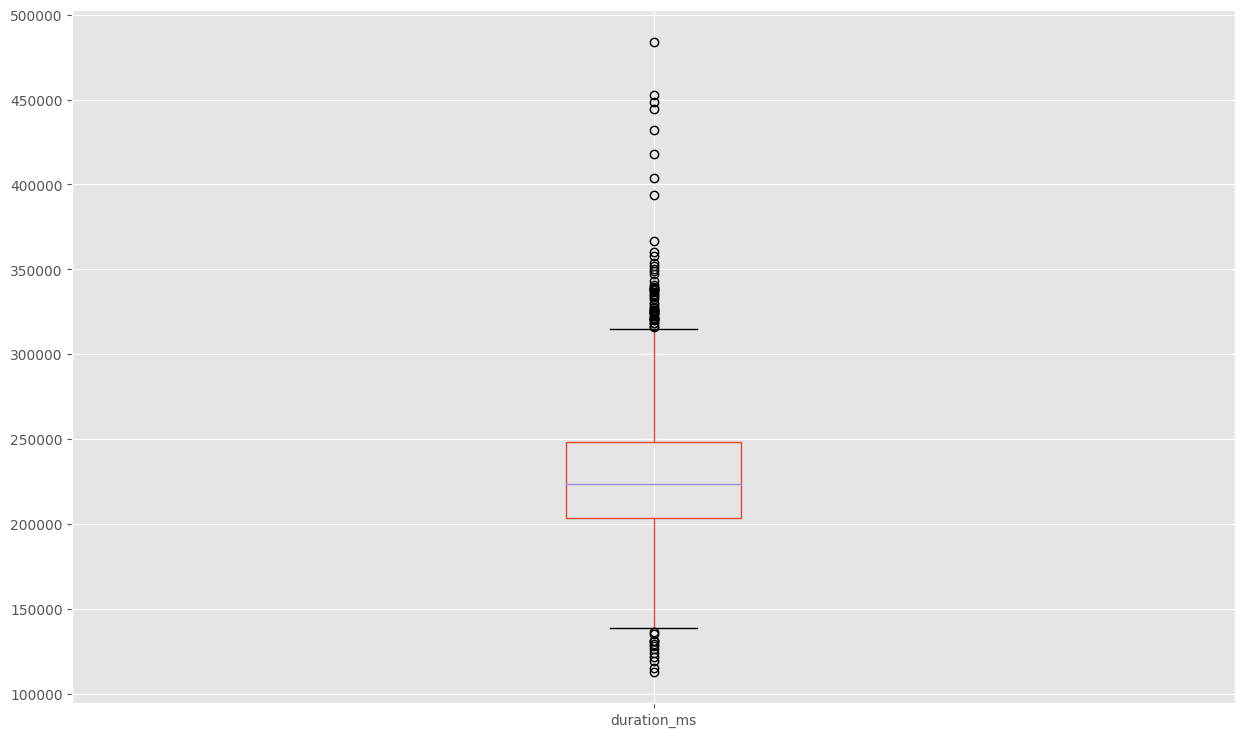

In [1401]:
songs_df[['duration_ms']].boxplot()

Sin embargo, cuando revisamos la variable de 'duration_ms' podemos observer que si existen algunos valores demasiado grandes, los cuales podrían afectar las predicciones de nuestros modelos.

Eliminamos valores atípicos

In [1402]:
songs_df = songs_df[songs_df["duration_ms"] < 375000]

Verificación de que removimos los valores atípicos

<Axes: >

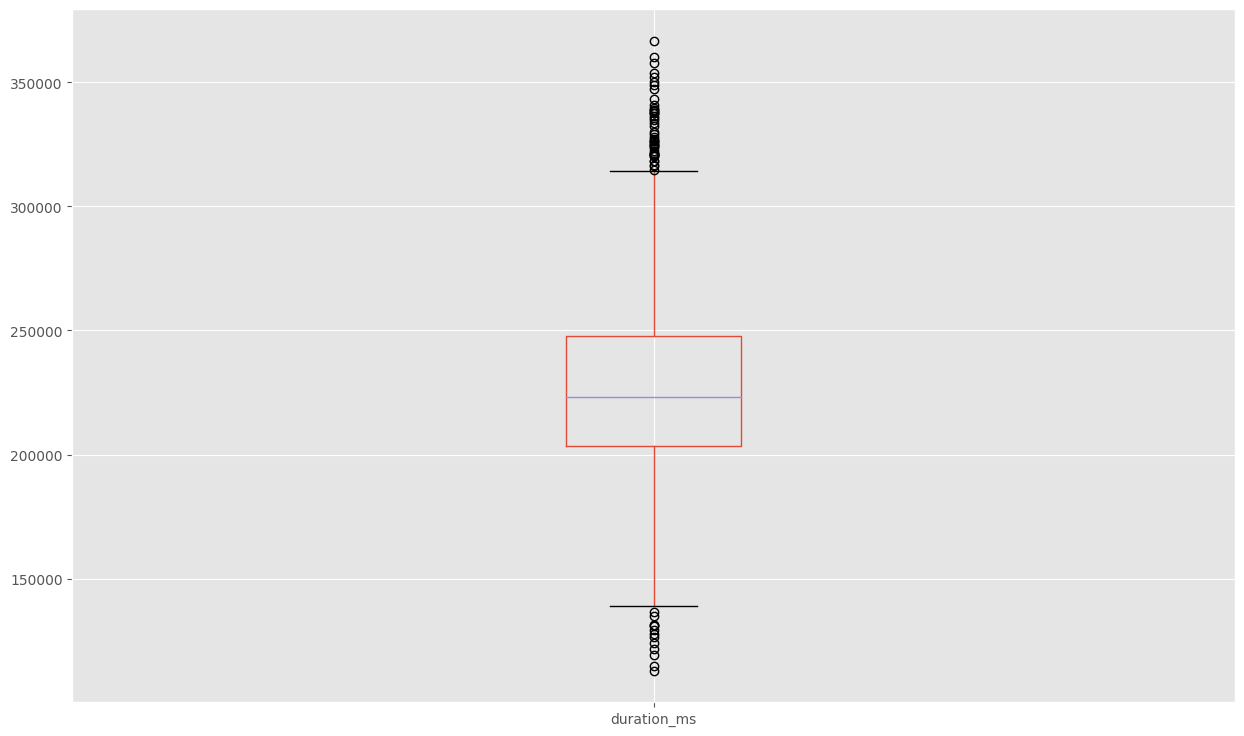

In [1403]:
songs_df[['duration_ms']].boxplot()

## Análisis de variables categóricas

In [1404]:
counts = songs_df['explicit'].value_counts()

print(counts)

False    1444
True      548
Name: explicit, dtype: int64


In [1405]:
counts = songs_df['genre'].value_counts()

print(counts)

pop                                      425
hip hop, pop                             277
hip hop, pop, R&B                        244
pop, Dance/Electronic                    221
pop, R&B                                 178
hip hop                                  123
hip hop, pop, Dance/Electronic            78
rock                                      58
rock, pop                                 43
Dance/Electronic                          38
rock, metal                               38
pop, latin                                28
pop, rock                                 26
set()                                     22
hip hop, Dance/Electronic                 16
latin                                     14
pop, rock, metal                          14
hip hop, pop, latin                       14
R&B                                       13
pop, rock, Dance/Electronic               13
country                                   10
metal                                      9
hip hop, p

Convertimos las variables categóricas a numéricas utilizando la función de get_dummies de pandas para transformar cada una de las categorías de nuestras variables categóricas en una variable nueva y colocarles un valor de 0 o 1 en caso la canción sea parte de la misma.

También quitamos la característica de danceability, ya que muestra un poco de correlación con loudness y valence, y también a los artistas, ya que son demasiadas categorías que no poseen mucho impacto al momento de realizar las predicciones.

In [1406]:
categorical_cols.remove('mode')
categorical_cols.remove('song')
categorical_cols.remove('artist')
numerical_cols.remove('popularity')
numerical_cols.remove('danceability')
numerical_cols.remove('key')
songs_df.pop('song')
songs_df.pop('artist')
songs_df.pop('key')
songs_df.pop('danceability')
songs_df = pd.get_dummies(songs_df, columns=['explicit', 'genre'])

## Obtención de datos de entrenamiento y de prueba

In [1407]:
target = songs_df.pop("popularity")
data = songs_df


In [1408]:
data_train, data_test, target_train, target_test = train_test_split(data, target,test_size=0.3,train_size=0.7, random_state=123)

### Métricas AIC y BIC

In [1409]:
# calculate aic for regression 
def calculate_aic(n, mse, num_params):
 aic = n * np.log(mse) + 2 * num_params
 return aic
# calculate bic for regression
def calculate_bic(n, mse, num_params):
 bic = n * np.log(mse) + num_params * np.log(n)
 return bic

# Modelos

## Modelo 1 (Regresión Lineal)

Realizaremos el modelo lineal usando múltiples predictores

In [1410]:
modelo1 = LinearRegression()
modelo1.fit(data_train, target_train)
y_pred_modelo1 = modelo1.predict(data_test)

In [1411]:
sm.OLS(target_train,data_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.478
Date:                Thu, 09 May 2024   Prob (F-statistic):            0.00996
Time:                        17:20:29   Log-Likelihood:                -6181.3
No. Observations:                1394   AIC:                         1.249e+04
Df Residuals:                    1330   BIC:                         1.283e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
duration_ms                                  1.627e-05    1.7e-05      0.957      0.339   -1.71e-05    4.96e-05
year                                            0.0519      0.116      0.447      0.655      -0.176       0.279
energy                                         -7.9190      5.825     -1.360      0.174     -19.345       3.507
loudness                                        0.6473      0.411      1.575      0.115      -0.159       1.453
mode                                           -0.5943      1.156     -0.514      0.607      -2.863       1.674
speechiness                                    -2.7395      6.907     -0.397      0.692     -16.289      10.810
acousticness                                    7.0998      3.772      1.882      0.060      -0.300      14.500
instrumentalness                               -7.2324      6.654     -1.087      0.277     -20.285       5.820
liveness                                       -1.9977      4.141     -0.482      0.630     -10.121       6.125
valence                                        -2.5951      2.913     -0.891      0.373      -8.310       3.120
tempo                                           0.0089      0.022      0.411      0.681      -0.034       0.051
explicit_False                                -36.3842    226.793     -0.160      0.873    -481.295     408.527
explicit_True                                 -37.4345    226.946     -0.165      0.869    -482.646     407.777
genre_Dance/Electronic                         -3.3594     10.027     -0.335      0.738     -23.029      16.310
genre_Folk/Acoustic, pop                       12.3970     17.004      0.729      0.466     -20.961      45.755
genre_Folk/Acoustic, rock                     -58.9395     22.300     -2.643      0.008    -102.686     -15.193
genre_Folk/Acoustic, rock, pop                  6.9340     22.355      0.310      0.756     -36.920      50.788
genre_R&B                                      -8.3178     11.752     -0.708      0.479     -31.372      14.736
genre_World/Traditional, Folk/Acoustic          8.4762     22.536      0.376      0.707     -35.733      52.686
genre_World/Traditional, hip hop               -7.5447     22.954     -0.329      0.742     -52.574      37.485
genre_World/Traditional, pop                   -1.2201     22.361     -0.055      0.956     -45.086      42.646
genre_World/Traditional, pop, Folk/Acoustic    10.0418     22.213      0.452      0.651     -33.534      53.618
genre_World/Traditional, rock                  -3.8305     22.566     -0.170      0.865     -48.099      40.438
genre_World/Traditional, rock, pop            -43.2272     17.062     -2.534      0.011     -76.699      -9.756
genre_country                                  -3.4052     

In [1412]:
explained_variance_modelo1=metrics.explained_variance_score(target_test, y_pred_modelo1)
mean_absolute_error_modelo1=metrics.mean_absolute_error(target_test, y_pred_modelo1) 
mse_modelo1=metrics.mean_squared_error(target_test, y_pred_modelo1) 
median_absolute_error_modelo1=metrics.median_absolute_error(target_test, y_pred_modelo1)
r2_modelo1=metrics.r2_score(target_test, y_pred_modelo1)
k = modelo1.coef_.size
n = data_train.shape[0]
aic_modelo1 = calculate_aic(n,mse_modelo1,k)
bic_modelo1 = calculate_bic(n,mse_modelo1,k)

print('explained_variance: ', round(explained_variance_modelo1,4))   
print('r2: ', round(r2_modelo1,4))
print('MAE: ', round(mean_absolute_error_modelo1,4))
print('MSE: ', round(mse_modelo1,4))
print('RMSE: ', round(np.sqrt(mse_modelo1),4))
print('AIC: ',round(aic_modelo1,4))
print('BIC: ',round(bic_modelo1,4))

explained_variance:  0.01
r2:  0.0075
MAE:  14.6729
MSE:  477.5917
RMSE:  21.8539
AIC:  8743.246
BIC:  9120.5212


#### Análisis de residuos

Text(0, 0.5, 'Residuales')

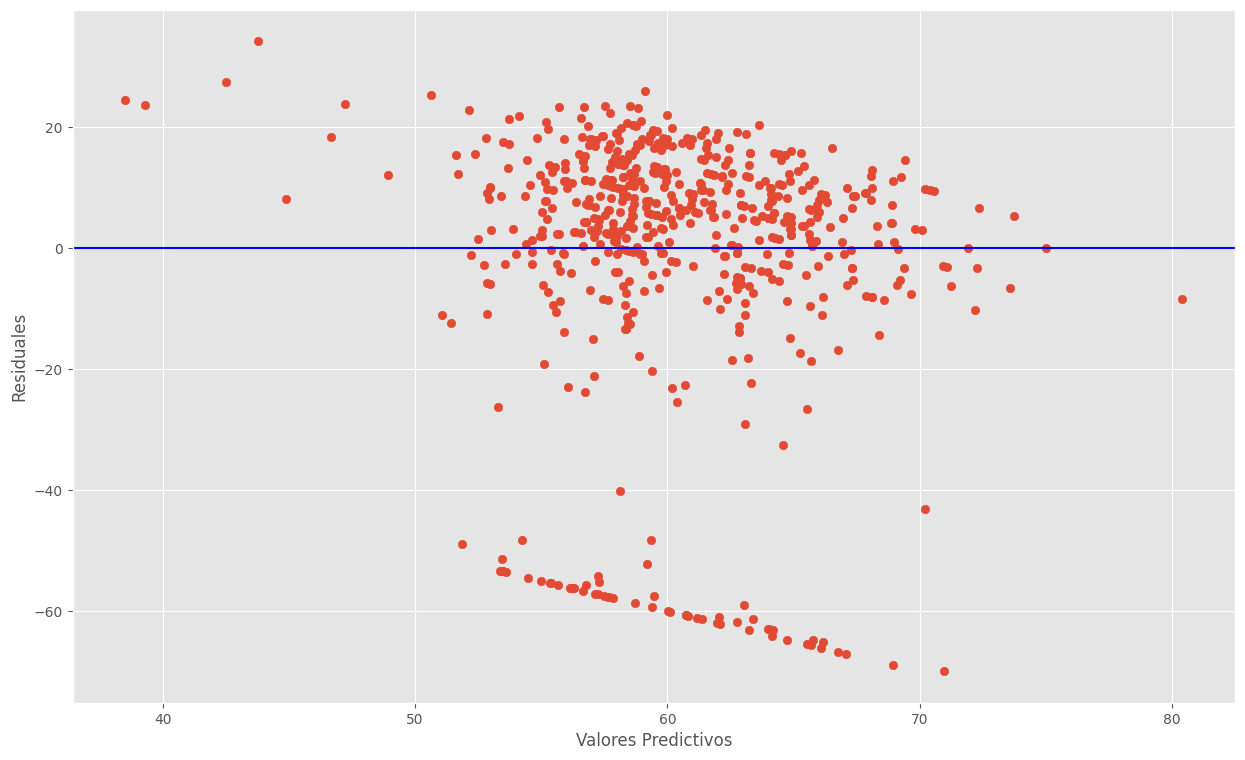

In [1413]:
resid_modelo1=target_test-y_pred_modelo1
plt.scatter(y_pred_modelo1,resid_modelo1)
plt.axhline(0,color='blue')
plt.xlabel('Valores Predictivos')
plt.ylabel('Residuales')

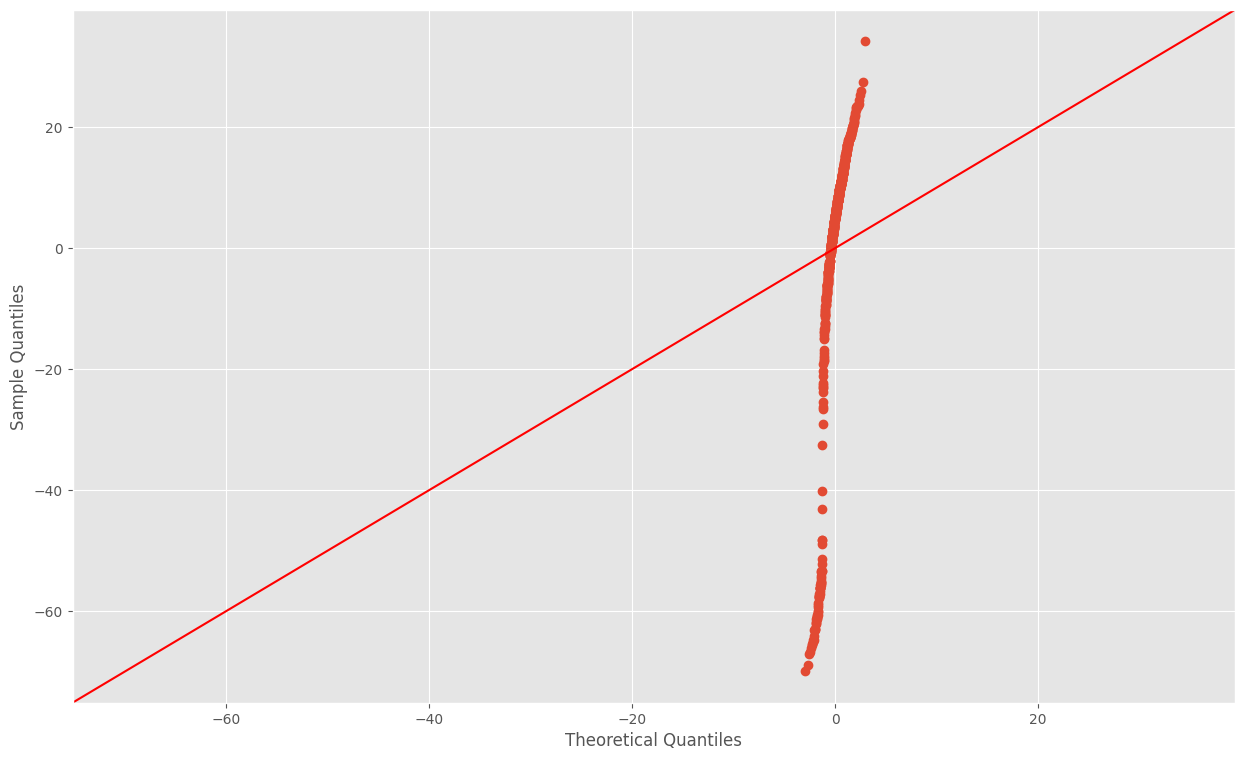

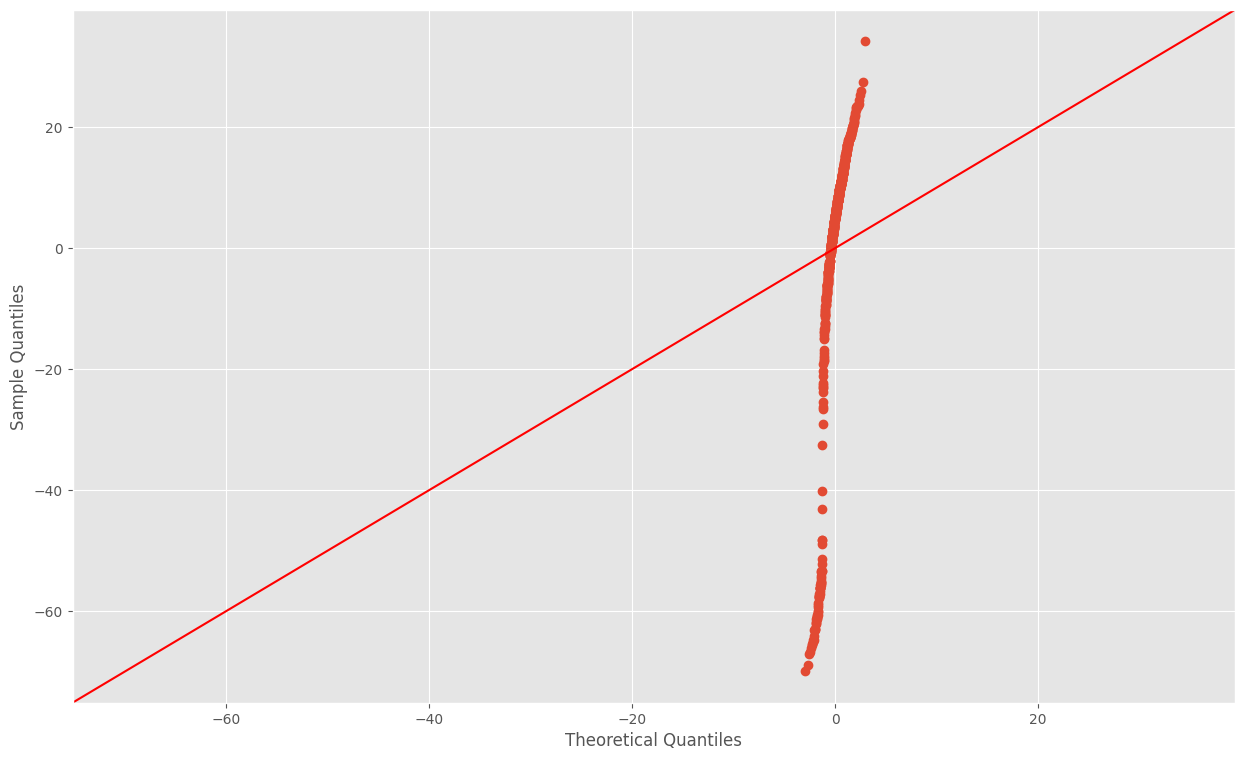

In [1414]:
sm.qqplot(resid_modelo1,line='45')

Basándonos en las gráficas de los residuos, podemos observar que las gráficas no se adaptan del todo a la R^2, y podemos ver que los mismos se agrupan de alguna manera, indicando que nuestro modelo no es el más adecuado para explicar la relación entre las variables.

In [1415]:
k,p=sm.stats.diagnostic.lilliefors(resid_modelo1)
print("p =",p)

p = 0.0009999999999998899


In [1416]:
x_pred_modelo1 = modelo1.predict(data_train)
mse_modelo1_train=metrics.mean_squared_error(target_train, x_pred_modelo1) 
rmse = np.sqrt(mse_modelo1_train)

print("MES_train: ",round(mse_modelo1_train,4))
print('MSE_test: ', round(mse_modelo1,4))
print('RMSE_train: ', round(rmse,4))

MES_train:  415.9518
MSE_test:  477.5917
RMSE_train:  20.3949


Podemos observar que para los datos de entrenamiento, la precisión es casi igual que para los datos de prueba. Indicandonos que posiblemente no exista ningún overfitting en nuestro modelo.

## Modelo 2 (Regresión Lineal con Selector de Predictores)

In [1417]:
lr = LinearRegression()

seleccionPredictores = SequentialFeatureSelector(lr, direction='backward', cv=5)
seleccionPredictores.fit(data_train[numerical_cols], target_train)

indicePredictores= seleccionPredictores.get_support(indices=True)

columnas = data_train[numerical_cols].columns

In [1418]:
X_train_stw= data_train.iloc[:,indicePredictores]
X_test_stw = data_test.iloc[:,indicePredictores]

In [1419]:
modelo2 = LinearRegression()
modelo2.fit(X_train_stw, target_train)

y_pred_modelo2 = modelo2.predict(X_test_stw)

In [1420]:
explained_variance_modelo2=metrics.explained_variance_score(target_test, y_pred_modelo2)
mean_absolute_error_modelo2=metrics.mean_absolute_error(target_test, y_pred_modelo2) 
mse_modelo2=metrics.mean_squared_error(target_test, y_pred_modelo2) 
mean_squared_log_error_modelo2=metrics.mean_squared_log_error(target_test, y_pred_modelo2)
median_absolute_error_modelo2=metrics.median_absolute_error(target_test, y_pred_modelo2)
r2_modelo2=metrics.r2_score(target_test, y_pred_modelo2)
k = modelo2.coef_.size
n = data_train.shape[0]
aic_modelo2 = calculate_aic(n,mse_modelo2,k)
bic_modelo2 = calculate_bic(n,mse_modelo2,k)

print('explained_variance: ', round(explained_variance_modelo2,4))   
print('mean_squared_log_error: ', round(mean_squared_log_error_modelo2,4))
print('r2: ', round(r2_modelo2,4))
print('MAE: ', round(mean_absolute_error_modelo2,4))
print('MSE: ', round(mse_modelo2,4))
print('RMSE: ', round(np.sqrt(mse_modelo2),4))
print('AIC: ',round(aic_modelo2,4))
print('BIC: ',round(bic_modelo2,4))

explained_variance:  -0.0006
mean_squared_log_error:  1.4867
r2:  -0.0021
MAE:  14.8655
MSE:  482.2261
RMSE:  21.9596
AIC:  8622.7078
BIC:  8648.9074


Text(0, 0.5, 'Residuales')

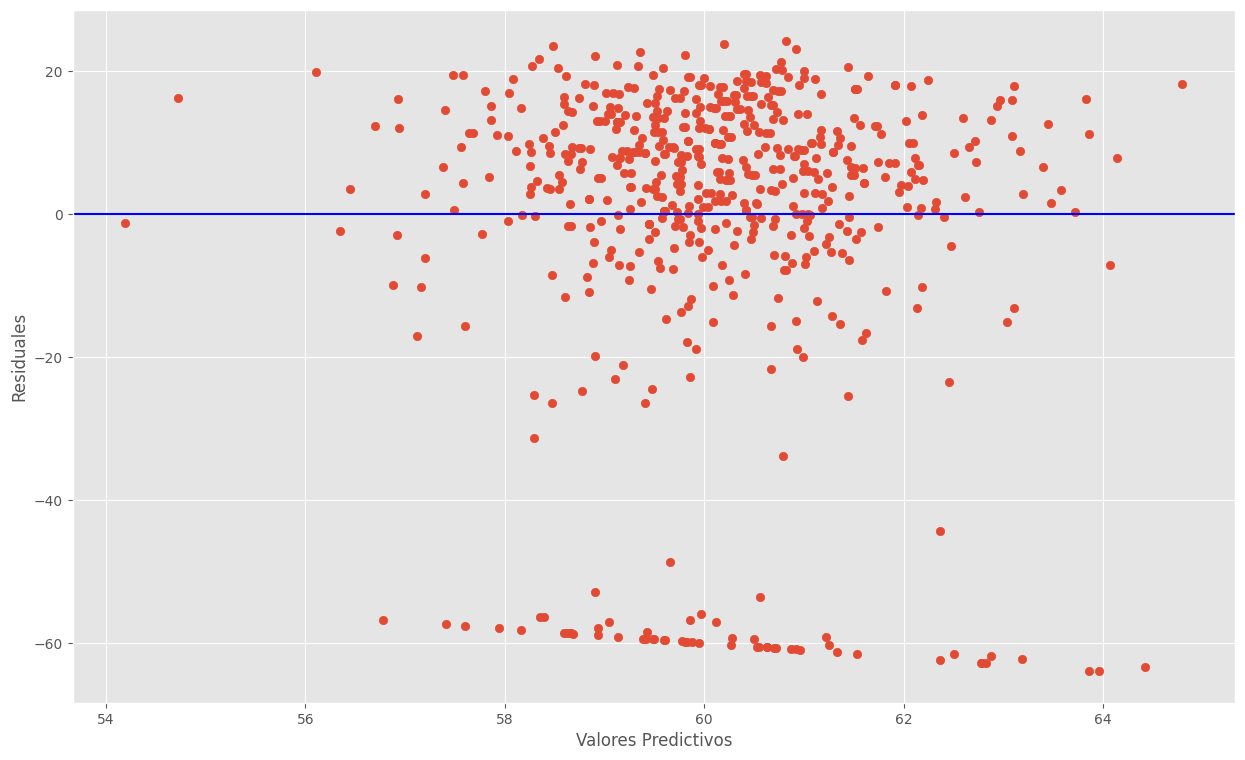

In [1421]:
resid_modelo2=target_test-y_pred_modelo2
plt.scatter(y_pred_modelo2,resid_modelo2)
plt.axhline(0,color='blue')
plt.xlabel('Valores Predictivos')
plt.ylabel('Residuales')

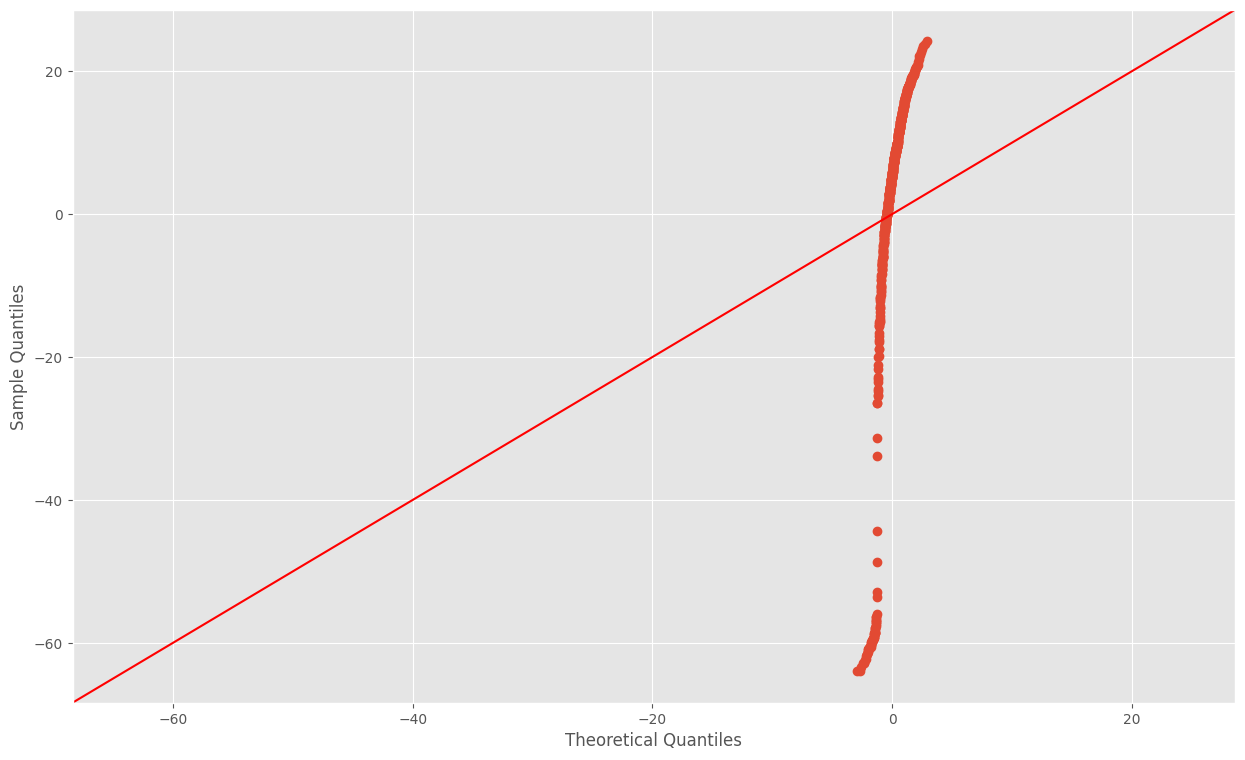

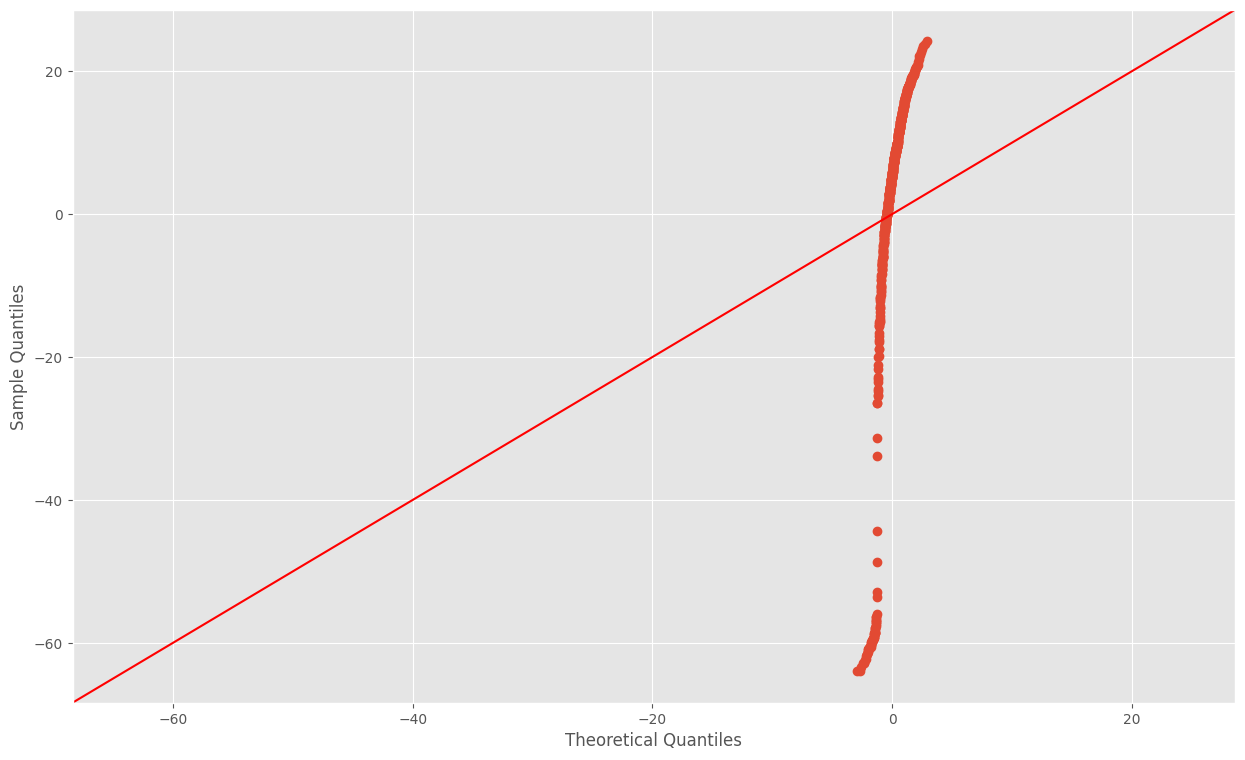

In [1422]:
sm.qqplot(resid_modelo2,line='45')

In [1423]:
k,p=sm.stats.diagnostic.lilliefors(resid_modelo2)
print("p =",p)

p = 0.0009999999999998899


In [1424]:
x_pred_modelo2 = modelo2.predict(X_train_stw)
mse_modelo2_train=metrics.mean_squared_error(target_train, x_pred_modelo2) 

print("MES_train: ",round(mse_modelo2_train,4))
print('MSE_test: ', round(mse_modelo2,4))

MES_train:  443.011
MSE_test:  482.2261


## Modelo 3 (Ridge)

In [1425]:
alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))


cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data_train, target_train,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)
train_error = -cv_results["train_score"]
print(f"Error medio cuadrado de la regresión con datos de entrenamiento:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

test_error = -cv_results["test_score"]
print(f"Error medio cuadrado de la regresion con los datos de prueba:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")
mse_alphas = [est[-1].cv_values_.mean(axis=0)
            for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas


Error medio cuadrado de la regresión con datos de entrenamiento:
416.238 ± 8.744
Error medio cuadrado de la regresion con los datos de prueba:
438.486 ± 80.461


,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,468.526119,468.525996,468.525838,468.525637,468.525382,468.525056,468.524641,468.524112,468.523437,468.522578,468.521484,468.520090,468.518313,468.516050,468.513167,468.509494,468.504816,468.498858,468.491272,468.481615
1,445.820241,445.820140,445.820011,445.819847,445.819637,445.819370,445.819030,445.818597,445.818045,445.817341,445.816445,445.815302,445.813847,445.811993,445.809632,445.806624,445.802793,445.797914,445.791702,445.783795
2,459.673223,459.673129,459.673010,459.672858,459.672665,459.672418,459.672104,459.671703,459.671193,459.670543,459.669715,459.668659,459.667315,459.665601,459.663419,459.660639,459.657098,459.652588,459.646846,459.639535
3,438.241985,438.241882,438.241751,438.241583,438.241370,438.241098,438.240751,438.240309,438.239747,438.239030,438.238116,438.236952,438.235470,438.233580,438.231174,438.228108,438.224204,438.219231,438.212899,438.204839
4,445.566962,445.566874,445.566763,445.566621,445.566439,445.566209,445.565915,445.565540,445.565063,445.564454,445.563679,445.562692,445.561433,445.559831,445.557789,445.555188,445.551875,445.547657,445.542286,445.535448


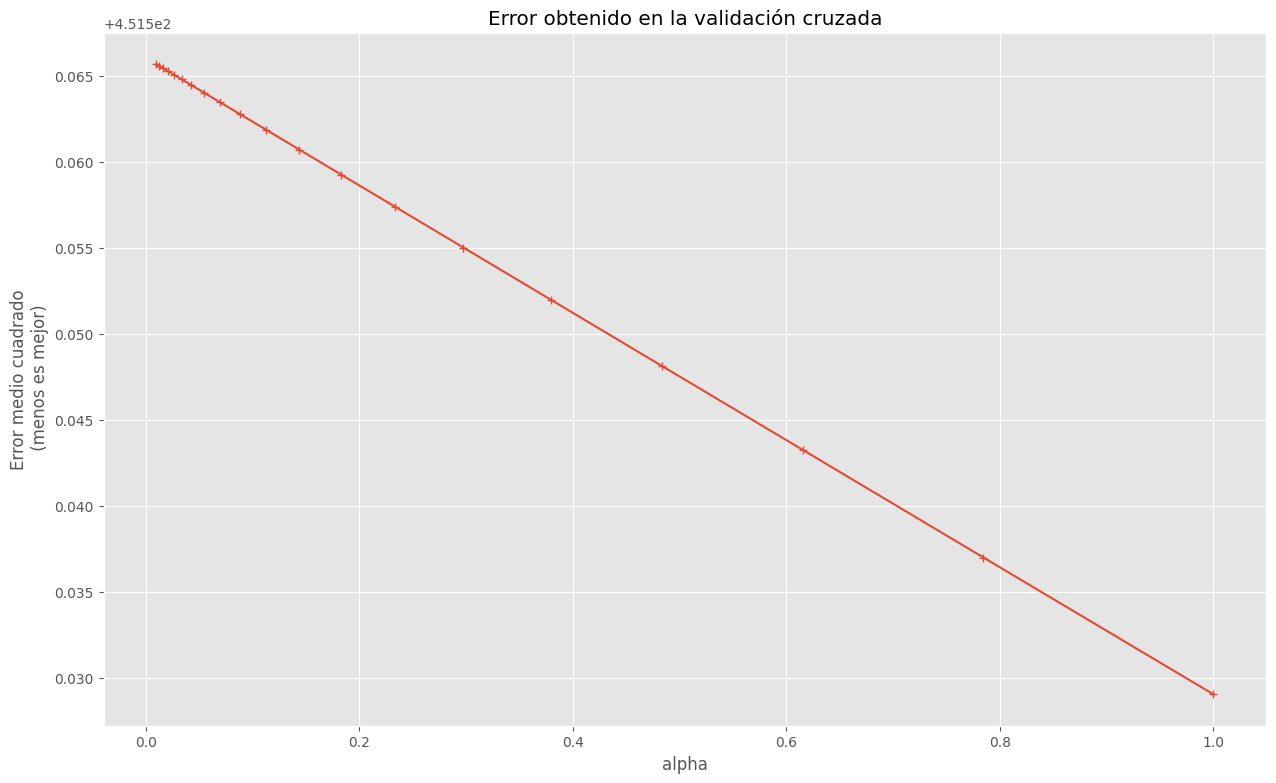

In [1426]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Error medio cuadrado\n (menos es mejor)")
plt.xlabel("alpha")
_ = plt.title("Error obtenido en la validación cruzada")

In [1427]:
mejores_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
mejores_alphas

[1.0, 1.0, 1.0, 1.0, 1.0]

In [1428]:
print(f"El mejor alfa es:\n"
      f"{np.mean(mejores_alphas):.2f} ± {np.std(mejores_alphas):.2f}")

El mejor alfa es:
1.00 ± 0.00


In [1429]:
alfa_modelo3 = np.mean(mejores_alphas)
modelo3 = Ridge(alpha=alfa_modelo3)
modelo3.fit(data_train, target_train)

y_pred_modelo3 = modelo3.predict(data_test)

In [1430]:
explained_variance_modelo3=metrics.explained_variance_score(target_test, y_pred_modelo3)
mean_absolute_error_modelo3=metrics.mean_absolute_error(target_test, y_pred_modelo3) 
mse_modelo3=metrics.mean_squared_error(target_test, y_pred_modelo3) 
mean_squared_log_error_modelo3=metrics.mean_squared_log_error(target_test, y_pred_modelo3)
median_absolute_error_modelo3=metrics.median_absolute_error(target_test, y_pred_modelo3)
r2_modelo3=metrics.r2_score(target_test, y_pred_modelo3)
k = modelo3.coef_.size
n = data_train.shape[0]
aic_modelo3 = calculate_aic(n,mse_modelo3,k)
bic_modelo3 = calculate_bic(n,mse_modelo3,k)

print('explained_variance: ', round(explained_variance_modelo3,4))   
print('mean_squared_log_error: ', round(mean_squared_log_error_modelo3,4))
print('r2: ', round(r2_modelo3,4))
print('MAE: ', round(mean_absolute_error_modelo3,4))
print('MSE: ', round(mse_modelo3,4))
print('RMSE: ', round(np.sqrt(mse_modelo3),4))
print('AIC: ',round(aic_modelo3,4))
print('BIC: ',round(bic_modelo3,4))

explained_variance:  0.0119
mean_squared_log_error:  1.4807
r2:  0.0096
MAE:  14.6484
MSE:  476.5862
RMSE:  21.8309
AIC:  8740.308
BIC:  9117.5832


## Modelo 4 (Lasso con Cross Validation)

In [1431]:
modelo4 = Lasso(alpha=0.10, tol=60, max_iter=10000, random_state=123, selection='cyclic')
modelo4.fit(data_train, target_train)

y_pred_modelo4 = modelo4.predict(data_test)

In [1432]:
explained_variance_modelo4=metrics.explained_variance_score(target_test, y_pred_modelo4)
mean_absolute_error_modelo4=metrics.mean_absolute_error(target_test, y_pred_modelo4) 
mse_modelo4=metrics.mean_squared_error(target_test, y_pred_modelo4) 
mean_squared_log_error_modelo4=metrics.mean_squared_log_error(target_test, y_pred_modelo4)
median_absolute_error_modelo4=metrics.median_absolute_error(target_test, y_pred_modelo4)
r2_modelo4=metrics.r2_score(target_test, y_pred_modelo4)
k = modelo4.coef_.size
n = data_train.shape[0]
aic_modelo4 = calculate_aic(n,mse_modelo4,k)
bic_modelo4 = calculate_bic(n,mse_modelo4,k)

print('explained_variance: ', round(explained_variance_modelo4,4))   
print('mean_squared_log_error: ', round(mean_squared_log_error_modelo4,4))
print('r2: ', round(r2_modelo4,4))
print('MAE: ', round(mean_absolute_error_modelo4,4))
print('MSE: ', round(mse_modelo4,4))
print('RMSE: ', round(np.sqrt(mse_modelo4),4))
print('AIC: ',round(aic_modelo4,4))
print('BIC: ',round(bic_modelo4,4))

explained_variance:  0.0267
mean_squared_log_error:  1.4761
r2:  0.0251
MAE:  14.6332
MSE:  469.0938
RMSE:  21.6586
AIC:  8718.2191
BIC:  9095.4942


## VIF

In [1433]:
X_train_const_VIF = sm.add_constant(data_train)

model_VIF = sm.OLS(target_train, X_train_const_VIF).fit()

print(model_VIF.summary())

predictions = model_VIF.predict(X_train_const_VIF)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_train.values, i) for i in range(data_train.shape[1])]
vif["features"] = data_train.columns

print(vif)

r_squared = model_VIF.rsquared
print('R-squared:', r_squared)

adjusted_r_squared = model_VIF.rsquared_adj
print('Adjusted R-squared:', adjusted_r_squared)

predictions_val = model_VIF.predict(sm.add_constant(data_test))
mse_train = mean_squared_error(target_train, predictions)
mse_val = mean_squared_error(target_test, predictions_val)

print('Training MSE:', mse_train)
print('Validation MSE:', mse_val)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.478
Date:                Thu, 09 May 2024   Prob (F-statistic):            0.00996
Time:                        17:20:31   Log-Likelihood:                -6181.3
No. Observations:                1394   AIC:                         1.249e+04
Df Residuals:                    1330   BIC:                         1.283e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


    VIF Factor                                  features
0     1.254271                               duration_ms
1     1.486856                                      year
2     2.585788                                    energy
3     2.042229                                  loudness
4     1.050920                                      mode
..         ...                                       ...
67         inf                           genre_rock, pop
68         inf         genre_rock, pop, Dance/Electronic
69         inf                    genre_rock, pop, metal
70         NaN  genre_rock, pop, metal, Dance/Electronic
71         inf                               genre_set()

[72 rows x 2 columns]
R-squared: 0.06542259131118344
Adjusted R-squared: 0.02115313511013428
Training MSE: 415.9518028939406
Validation MSE: 477.61168091204627


MSE (test): 470.04790910019454
MAE (test): 14.62378636918799
RMSE (test): 21.680588301524352


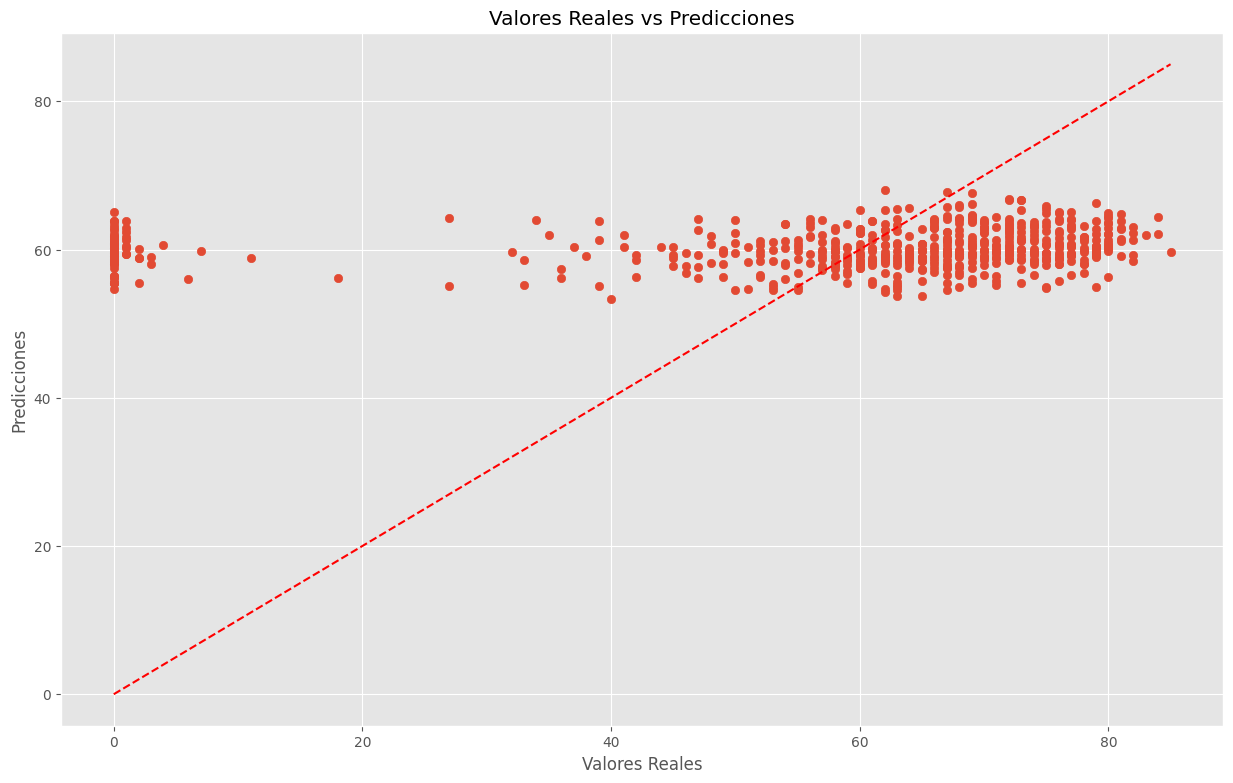

In [1434]:
# Define the model
model = Lasso(alpha=0.1)

# Fit the model
model.fit(data_train, target_train)

# Make predictions
y_pred_test = model.predict(data_test)

# Calculate MSE and RMSE
mse_test = mean_squared_error(target_test, y_pred_test)
print("MSE (test):", mse_test)
mae_test = mean_absolute_error(target_test, y_pred_test)
print("MAE (test):", mae_test)
rmse_test = np.sqrt(mse_test)
print("RMSE (test):", rmse_test)

# Plot the predictions
plt.scatter(target_test, y_pred_test)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs Predicciones')

# Dibujar una línea diagonal (indicando un modelo perfecto)
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], color='red', linestyle='--')

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.478
Date:                Thu, 09 May 2024   Prob (F-statistic):            0.00996
Time:                        17:20:32   Log-Likelihood:                -6181.3
No. Observations:                1394   AIC:                         1.249e+04
Df Residuals:                    1330   BIC:                         1.283e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Análisis de multicolinealidad (VIF):
                                     Feature       VIF
0                                duration_ms  1.254271
1                                       year  1.486856
2                                     energy  2.585788
3                                   loudness  2.042229
4                                       mode  1.050920
..                                       ...       ...
67                           genre_rock, pop       inf
68         genre_rock, pop, Dance/Electronic       inf
69                    genre_rock, pop, metal       inf
70  genre_rock, pop, metal, Dance/Electronic       NaN
71                               genre_set()       inf

[72 rows x 2 columns]


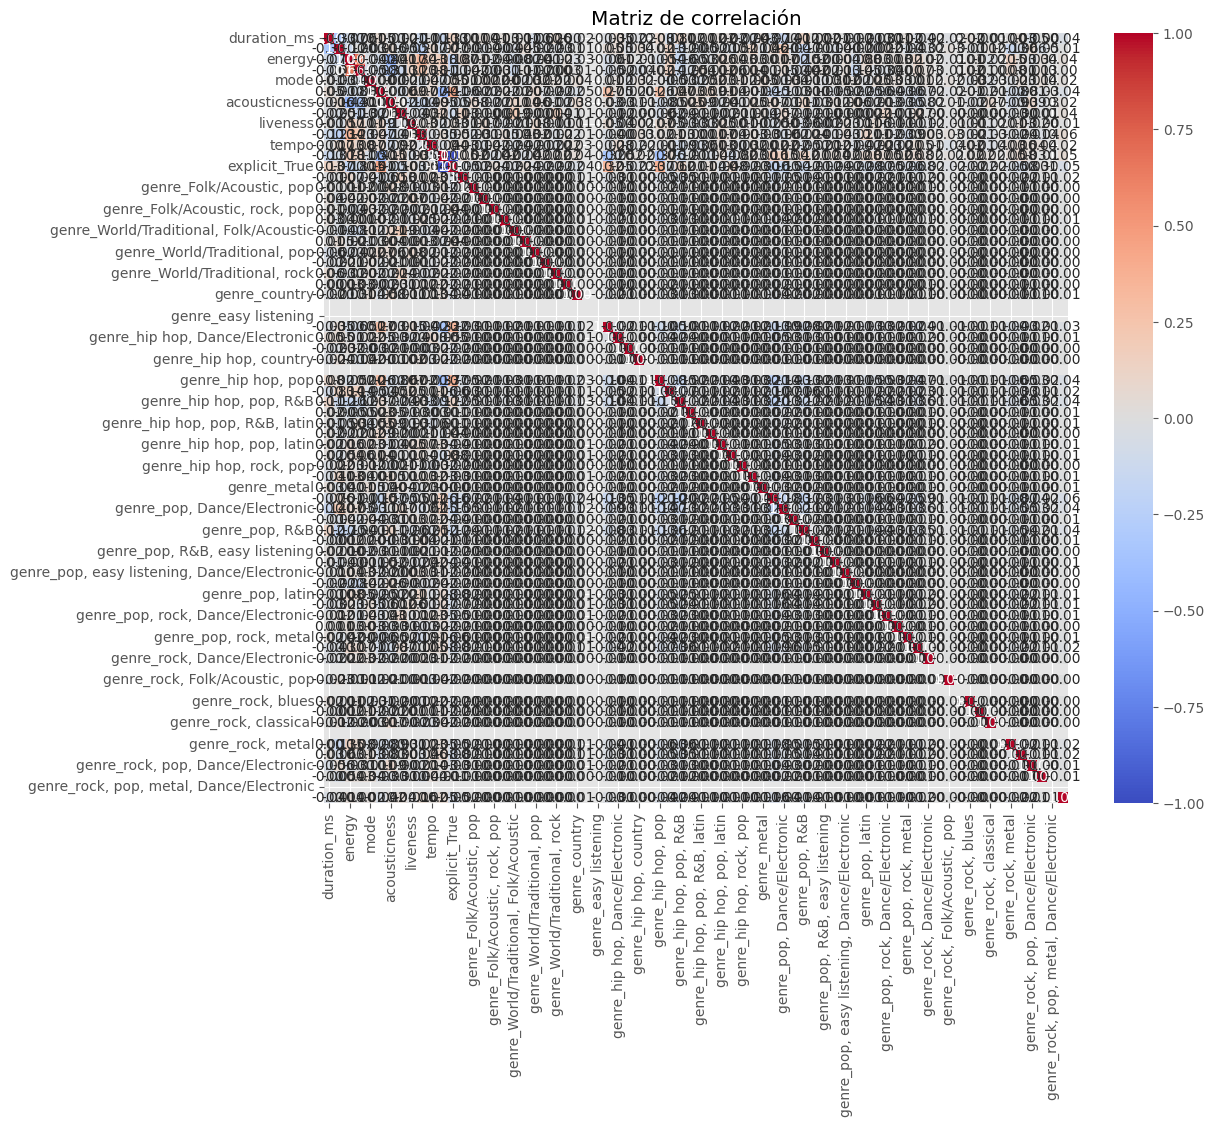

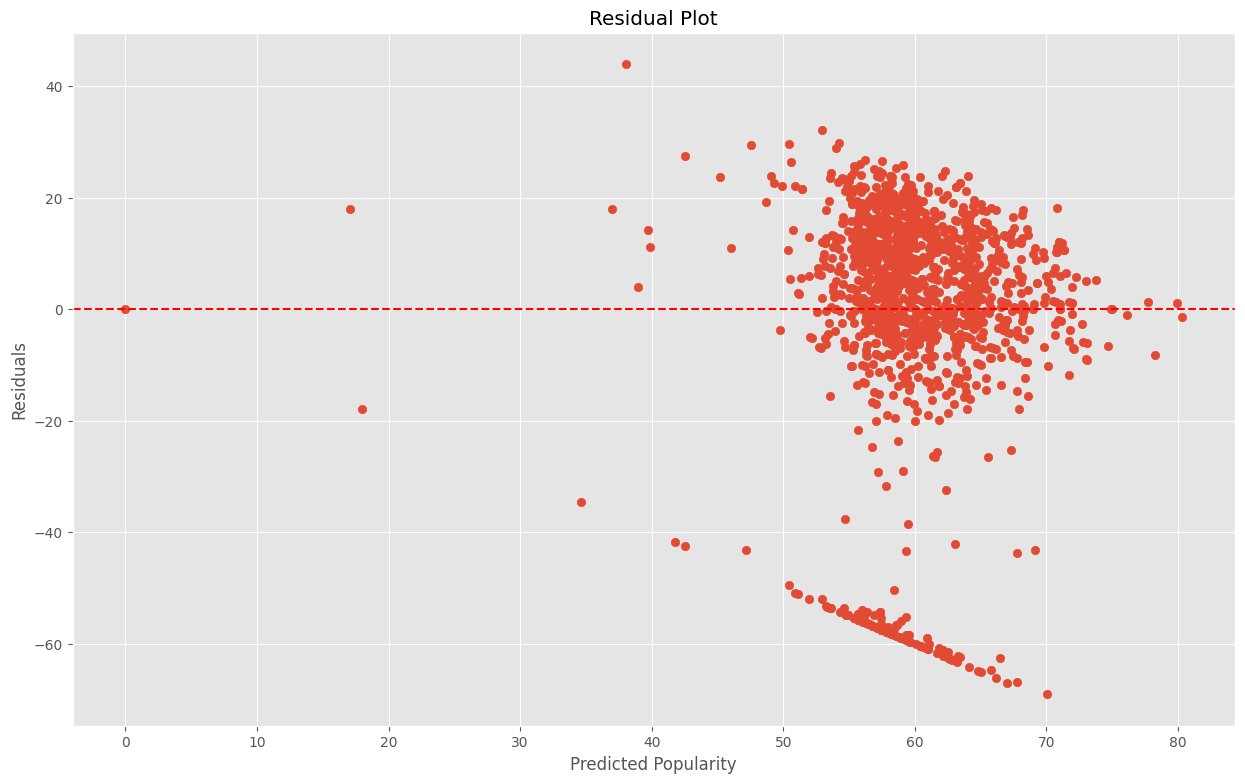


R^2 en los datos de prueba: 0.0074438491966305476


In [1435]:
# Añadir una constante para el término de intercepción
X_train_const_VIF = sm.add_constant(data_train)

# Modelo de regresión lineal
model_VIF = sm.OLS(target_train, X_train_const_VIF).fit()

# Resumen del modelo
print(model_VIF.summary())

# Análisis de multicolinealidad (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = data_train.columns
vif_data["VIF"] = [variance_inflation_factor(data_train.values, i) for i in range(len(data_train.columns))]
print("\nAnálisis de multicolinealidad (VIF):")
print(vif_data)

# Matriz de correlación
correlation_matrix = data_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.title("Matriz de correlación")
plt.show()

# Análisis de residuos
residuals = target_train - model_VIF.predict(X_train_const_VIF)
plt.scatter(model_VIF.predict(X_train_const_VIF), residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Evaluar el modelo en los datos de prueba
X_test_const_VIF = sm.add_constant(data_test)
test_predictions = model_VIF.predict(X_test_const_VIF)
test_residuals = target_test - test_predictions
test_r_squared = r2_score(target_test, test_predictions)
print("\nR^2 en los datos de prueba:", test_r_squared)
